In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2, gc
from matplotlib import pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [56]:
DATA_DIR = '/home/chicm/data/planet'
RESULT_DIR = DATA_DIR+'/results'

df_test = pd.read_csv(DATA_DIR+'/sample_submission.csv')

print(df_test.values[:10])

[['test_0' 'primary clear agriculture road water']
 ['test_1' 'primary clear agriculture road water']
 ['test_2' 'primary clear agriculture road water']
 ['test_3' 'primary clear agriculture road water']
 ['test_4' 'primary clear agriculture road water']
 ['test_5' 'primary clear agriculture road water']
 ['test_6' 'primary clear agriculture road water']
 ['test_7' 'primary clear agriculture road water']
 ['test_8' 'primary clear agriculture road water']
 ['test_9' 'primary clear agriculture road water']]


In [57]:
labels = ['haze', 'cultivation', 'blooming', 'partly_cloudy', 'habitation', 'primary',
            'road', 'agriculture', 'selective_logging', 'artisinal_mine', 'slash_burn',
            'blow_down', 'cloudy', 'bare_ground', 'conventional_mine', 'clear', 'water']

cloudy_index = 12 
PREDICTS_FILE = RESULT_DIR + '/preds'

In [6]:
import bcolz

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

In [50]:
x_test = []
for f, tags in tqdm(df_test.values, miniters=10000):
    fn = DATA_DIR+'/test-jpg/'+f+'.jpg'
    img = cv2.imread(fn)
    x_test.append(img)

100%|██████████| 40669/40669 [00:37<00:00, 1076.14it/s]


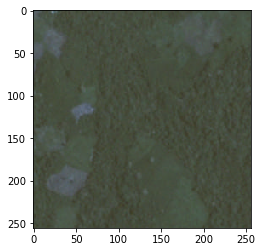

In [51]:
plot(x_test[1101])

In [22]:
preds = load_array(PREDICTS_FILE)

In [23]:
preds[:5]

array([[ 0.01041296,  0.06117052,  0.01875316,  0.01498115,  0.0084371 ,
         0.99447513,  0.02619349,  0.05540305,  0.00763869,  0.00288514,
         0.00382301,  0.00421963,  0.00177683,  0.00960025,  0.00163995,
         0.95134079,  0.05712077],
       [ 0.00192637,  0.07143894,  0.02871962,  0.05925711,  0.00554475,
         0.99649942,  0.0132723 ,  0.03751978,  0.01634973,  0.0026219 ,
         0.00273673,  0.01487179,  0.00153201,  0.00298589,  0.00154697,
         0.86738294,  0.01148363],
       [ 0.00148707,  0.01015364,  0.00152114,  0.99995679,  0.00256199,
         0.99617445,  0.01828577,  0.02012934,  0.00182815,  0.00184112,
         0.00310062,  0.00259925,  0.00397995,  0.00204873,  0.00179134,
         0.00148658,  0.05464028],
       [ 0.00241703,  0.09884592,  0.02972267,  0.03624406,  0.00800206,
         0.9978556 ,  0.03859733,  0.11364193,  0.01726036,  0.00213463,
         0.00413661,  0.01054293,  0.00152082,  0.0047776 ,  0.00157322,
         0.84845674

In [24]:
df_test[:2]

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water


In [59]:
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [87]:
def get_tags(index):
    strtags = ''
    tags = preds[index]
    #print(tags)
    for i, tag in enumerate(tags):
        if tag > 0.18:
            strtags = strtags+','+inv_label_map[i]+'('+str(tag)+')'
    return strtags

In [91]:
def max_other_tag(index):
    tags = preds[index]
    max = 0.
    for i, tag in enumerate(tags):
        if i != 12 and tag > max:
            max = tag
    return max, tags[12]

In [92]:
tags = get_tags(1101)
print(tags)

,cultivation(0.881366),primary(0.99806),agriculture(0.82039),clear(0.964057)


## fix cloudy

In [112]:
cloudy_row = [0]*17
cloudy_row[12] = 0.99
print(cloudy_row)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.99, 0, 0, 0, 0]


In [114]:

for i, row in enumerate(preds):
    o, c = max_other_tag(i)
    if c > 0.18 and o >= 0.18:
        if c >= o:
            preds[i] = cloudy_row
        else:
            preds[i][12] = 0

In [115]:
count = 0
cloudy_indexes = []
for i, row in enumerate(preds):
    o, c = max_other_tag(i)
    if c >= 0.18 and o >= 0.18:
        count +=1
        cloudy_indexes.append(i)
print(count)
print(cloudy_indexes[:5])

0
[]


## save fixed preds

In [116]:
import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
save_array(RESULT_DIR+'/preds_fixed', preds)

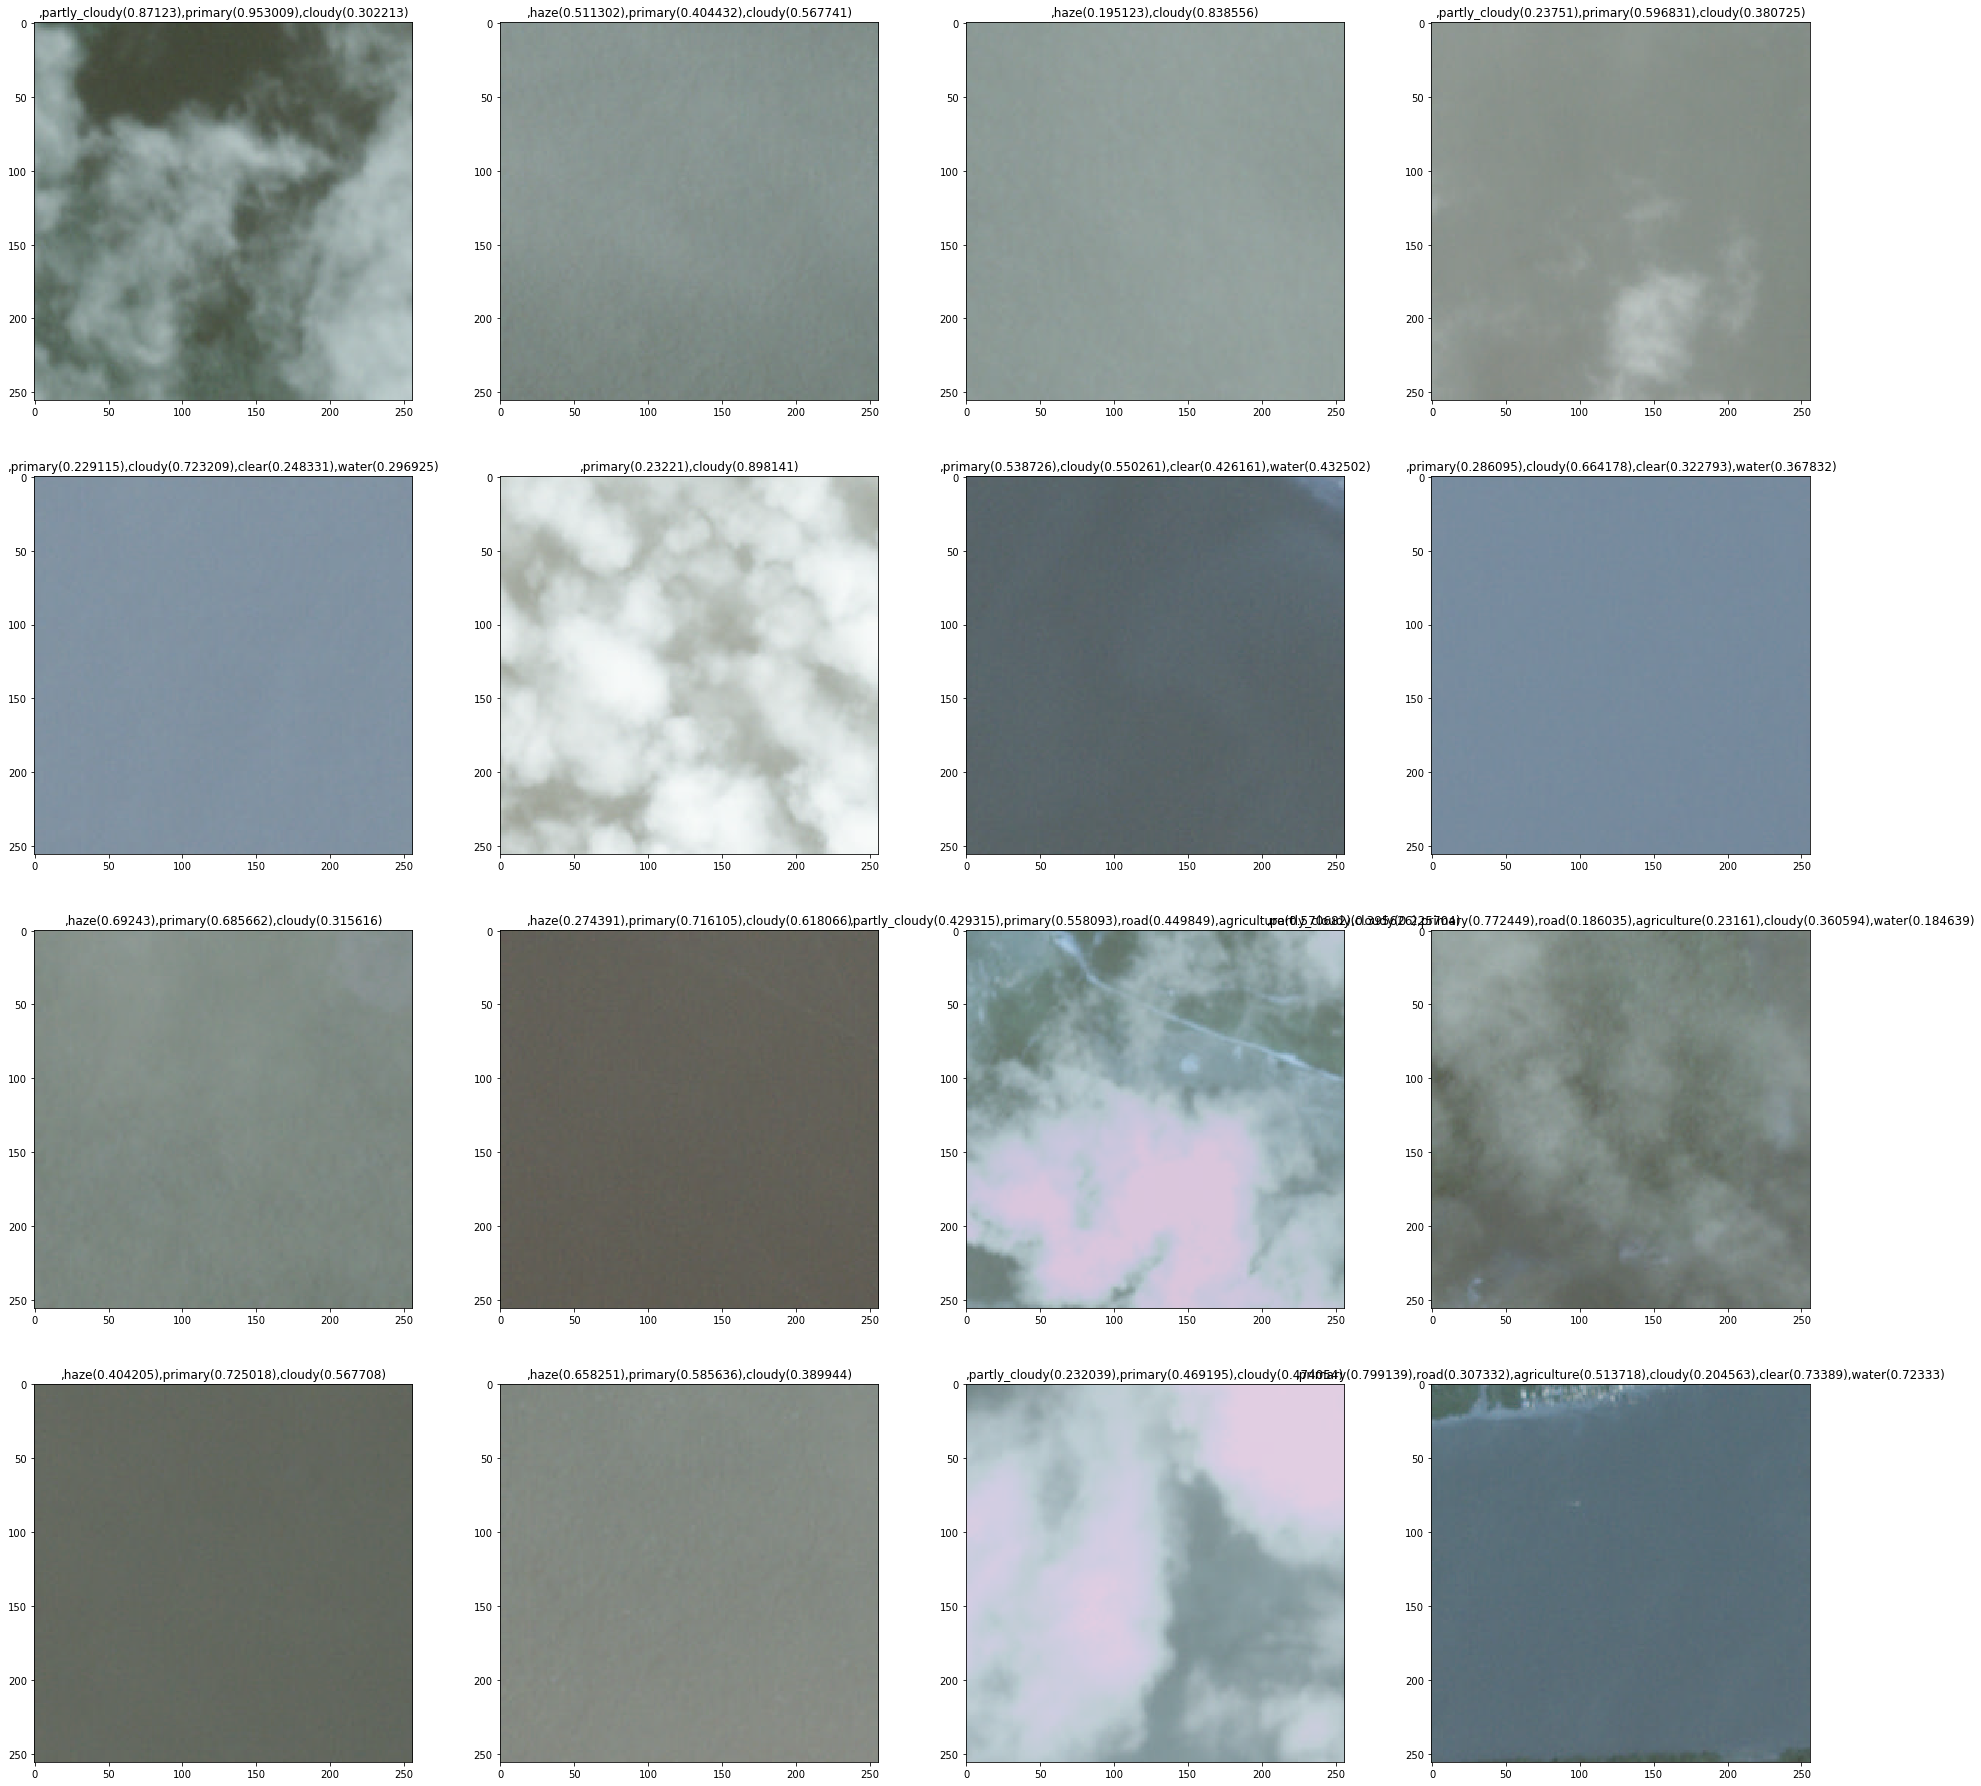

In [97]:
plt.figure(figsize=(32,32))
for i in range(16):
    plt.subplot(4,4,i+1)
    img_ix = cloudy_indexes[i]
    plt.imshow(x_test[img_ix])
    plt.title(get_tags(img_ix))

In [58]:
df = pd.DataFrame(preds, columns=labels)
df[:5]

,haze,cultivation,blooming,partly_cloudy,habitation,primary,road,agriculture,selective_logging,artisinal_mine,slash_burn,blow_down,cloudy,bare_ground,conventional_mine,clear,water
0,0.010413,0.061171,0.018753,0.014981,0.008437,0.994475,0.026193,0.055403,0.007639,0.002885,0.003823,0.004220,0.001777,0.009600,0.001640,0.951341,0.057121
1,0.001926,0.071439,0.028720,0.059257,0.005545,0.996499,0.013272,0.037520,0.016350,0.002622,0.002737,0.014872,0.001532,0.002986,0.001547,0.867383,0.011484
2,0.001487,0.010154,0.001521,0.999957,0.002562,0.996174,0.018286,0.020129,0.001828,0.001841,0.003101,0.002599,0.003980,0.002049,0.001791,0.001487,0.054640
3,0.002417,0.098846,0.029723,0.036244,0.008002,0.997856,0.038597,0.113642,0.017260,0.002135,0.004137,0.010543,0.001521,0.004778,0.001573,0.848457,0.031376
4,0.002046,0.010045,0.001570,0.871230,0.006314,0.953009,0.017054,0.042508,0.001661,0.001607,0.001845,0.001687,0.302213,0.003444,0.001759,0.001953,0.127770


In [89]:
print(preds[0])
oldrow = preds[0]
oldrow = [ 0.01041296,  0.06117052,  0.01875316,  0.01498115,  0.0084371,   0.99447513,
  0.02619349,  0.05540305,  0.00763869,  0.00288514,  0.00382301,  0.00421963,
  0.00177683,  0.00960025,  0.00163995,  0.95134079,  1.05712077]
print(preds[0])
#print(newrow)
#preds[0] = newrow
#print(preds[0])
#preds[0] = oldrow
#print(preds[0])
#preds[0] = [ 0.01041296,  0.06117052,  0.01875316,  0.01498115,  0.0084371,   0.99447513,
#  0.02619349,  0.05540305,  0.00763869,  0.00288514,  0.00382301,  0.00421963,
#  0.00177683,  0.00960025,  0.00163995,  0.95134079,  0.05712077]
#print(preds[0])

[ 0.01041296  0.06117052  0.01875316  0.01498115  0.0084371   0.99447513
  0.02619349  0.05540305  0.00763869  0.00288514  0.00382301  0.00421963
  0.00177683  0.00960025  0.00163995  0.95134079  0.05712077]
[ 0.01041296  0.06117052  0.01875316  0.01498115  0.0084371   0.99447513
  0.02619349  0.05540305  0.00763869  0.00288514  0.00382301  0.00421963
  0.00177683  0.00960025  0.00163995  0.95134079  0.05712077]


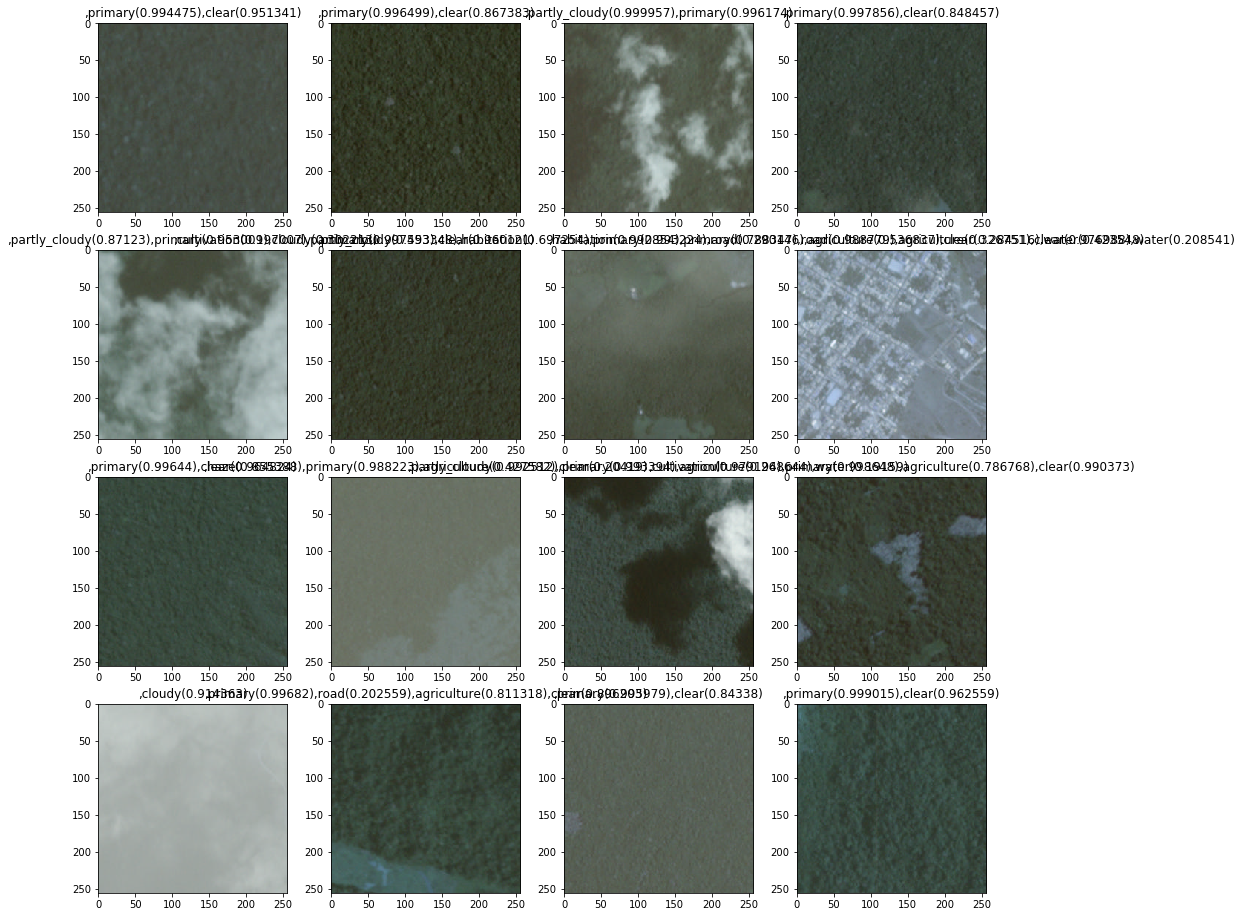

In [108]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_test[i])
    plt.title(get_tags(i))